# 🚏 City2Graph + GNN Demo: Paris Street Network

This notebook demonstrates how **city2graph** and **Graph Neural Networks (GNNs)** can be used to analyze urban systems. 

We will:
1. Download Paris’s street network from OpenStreetMap.
2. Convert it into a graph using `city2graph`.
3. Build a **Graph Convolutional Network (GCN)** with PyTorch Geometric.
4. Train the GCN to predict whether a street node is a **major intersection**.

This is a **toy example** — but the workflow generalizes to tasks like flood exposure prediction, land value modelling, or multi-city comparisons.

In [29]:
import osmnx as ox
import networkx as nx
import city2graph as c2g
import contextily as ctx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML


ox.settings.log_console = False  # silence osmnx logs

In [17]:
def get_node_positions(gdf):
    """Extract node positions from GeoDataFrame."""
    node_positions = {}
    for id, geom in gdf["geometry"].items():
        if geom.geom_type == "Point":
            node_positions[id] = (geom.x, geom.y)
        else:
            centroid = geom.centroid
            node_positions[id] = (centroid.x, centroid.y)
    return node_positions

def plot_graph(graph,
               title,
               node_positions,
               add_basemap=False,
               crs=None):
    """Plot a network graph with color-coded nodes based on degree centrality."""
    # Compute degree centrality for node coloring
    node_degrees = dict(graph.degree())
    node_colors = [node_degrees.get(node, 0) for node in graph.nodes()]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Set equal aspect ratio to maintain map proportions
    ax.set_aspect("equal")

    # Plot the edges with better color
    nx.draw_networkx_edges(graph, pos=node_positions,
                          edge_color="grey",
                          alpha=0.5,
                          width=0.5,
                          ax=ax)

    # Plot the POIs with beautiful color scheme
    nodes = nx.draw_networkx_nodes(graph, pos=node_positions,
                          node_size=30,
                          node_color=node_colors,
                          cmap=plt.cm.plasma,
                          alpha=0.9,
                          linewidths=0.5,
                          ax=ax)

    # Add basemap if requested - with no buffer/margin
    if add_basemap and crs:
        ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Set exact limits based on node positions to avoid any buffer
    node_xs = [pos[0] for pos in node_positions.values()]
    node_ys = [pos[1] for pos in node_positions.values()]
    ax.set_xlim(min(node_xs), max(node_xs))
    ax.set_ylim(min(node_ys), max(node_ys))

    # Add a colorbar with better styling
    cbar = plt.colorbar(nodes, ax=ax, label="Degree Centrality", shrink=0.8)
    cbar.ax.tick_params(labelsize=10)

    plt.title(title, fontsize=14, fontweight="bold", pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()




## 1. Download Paris Street Network

In [3]:
city = "Paris, France"
G = ox.graph_from_place(city, network_type="drive")
Paris_gdf = ox.graph_to_gdfs(G)

In [24]:
paris_nodes, paris_edges = Paris_gdf
paris_nodes = paris_nodes.reset_index(drop=True)
paris_nodes = paris_nodes.to_crs(epsg=6677)

## 2. Convert to CityGraph (city2graph)

In [25]:
parisknn_l1_nodes, parisknn_l1_edges = c2g.knn_graph(paris_nodes)
node_positions = get_node_positions(paris_nodes)


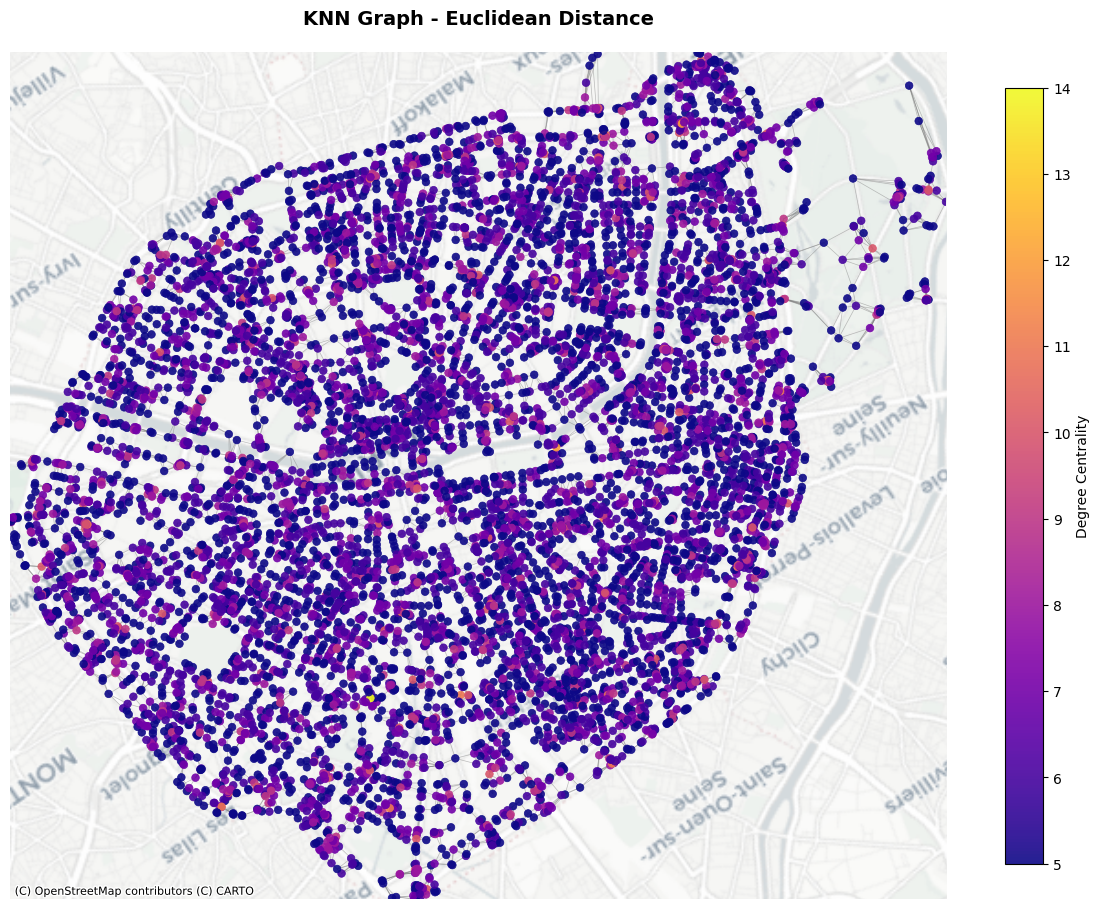

In [27]:
knn_l2_G = c2g.knn_graph(paris_nodes,
                                distance_metric="euclidean",
                                as_nx=True)

plot_graph(knn_l2_G,
           title="KNN Graph - Euclidean Distance",
           node_positions=node_positions,
           add_basemap=True,
           crs=paris_nodes.crs)



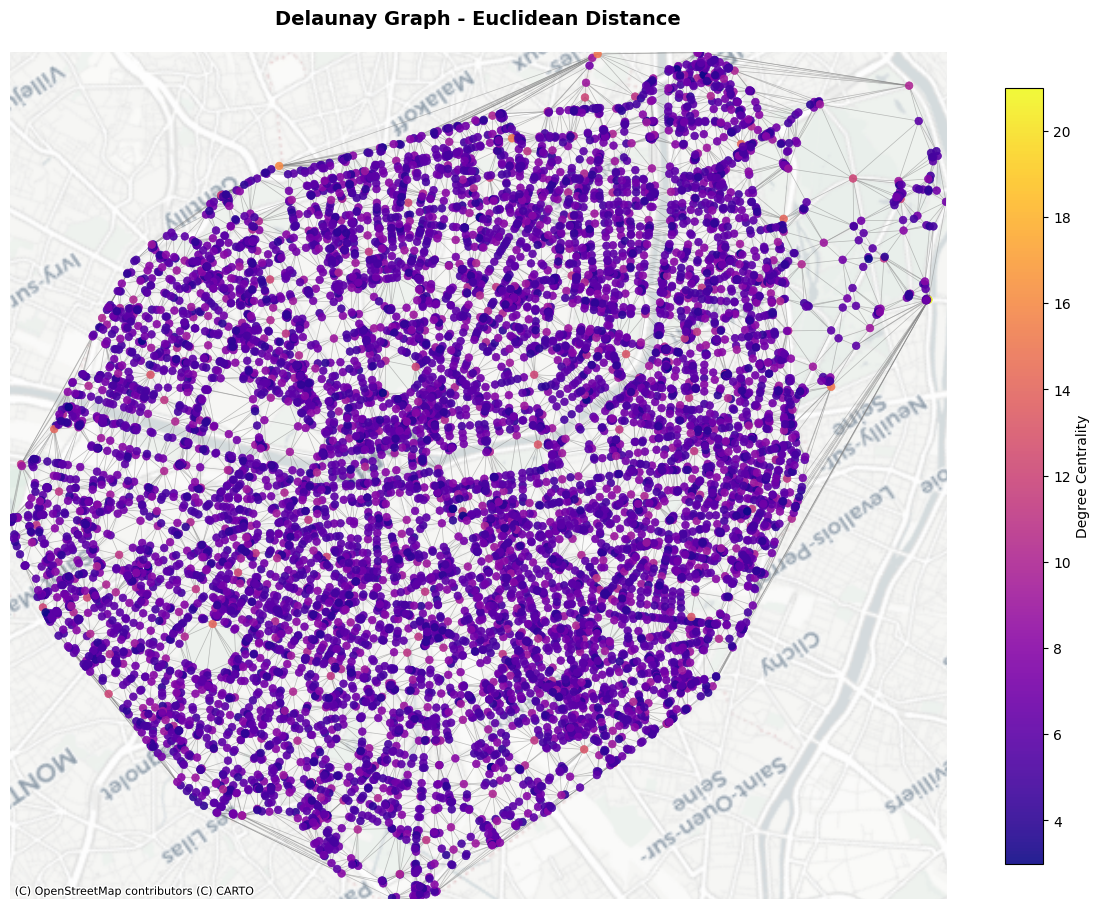

In [31]:
del_l2_G = c2g.delaunay_graph(paris_nodes,
                                     distance_metric="euclidean",
                                     as_nx=True)

plot_graph(del_l2_G,
           title="Delaunay Graph - Euclidean Distance",
           node_positions=node_positions,
           add_basemap=True,
           crs=paris_nodes.crs)

In [ ]:



# Convert edge index to PyTorch tensor
edge_index = torch.tensor(list(cgraph.edge_index.values.T), dtype=torch.long)

# Features: degree + coordinates
deg = np.array([d for _, d in G.degree()])
coords = np.stack([nodes.geometry.x.values, nodes.geometry.y.values], axis=1)
x = torch.tensor(np.hstack([deg.reshape(-1,1), coords]), dtype=torch.float)

# Labels: binary target (major intersection = degree > 3)
y = torch.tensor((deg > 3).astype(int), dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)
data

c:\Users\Tyler Marino\OneDrive\Desktop\GradSchool\Saclay\Stage-Progress\CityVenv\Lib\site-packages\city2graph\proximity.py:1750: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


KeyboardInterrupt: 

## 3. Visualize Nodes by Label (Ground Truth)

NameError: name 'y' is not defined

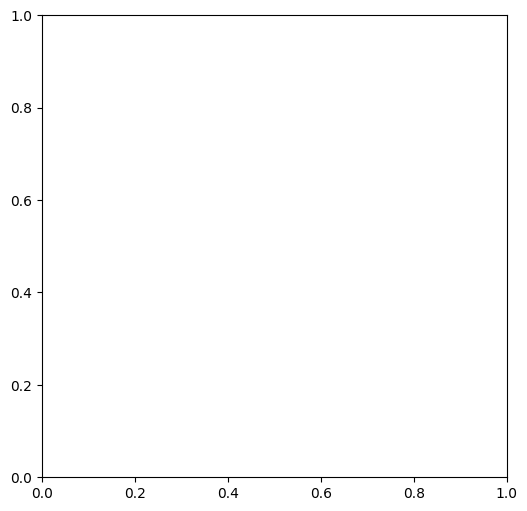

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
nodes.plot(ax=ax, markersize=5, color=["red" if label==1 else "blue" for label in y.numpy()])
ax.set_title("Paris intersections: red = major (>3 roads), blue = minor")
plt.show()

## 4. Define a Simple Graph Convolutional Network

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

## 5. Train/Test Split and Training Loop

In [ ]:
n = data.num_nodes
idx = torch.randperm(n)
train_mask = idx[:int(0.8*n)]
test_mask = idx[int(0.8*n):]

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        acc = (pred[test_mask] == data.y[test_mask]).sum() / len(test_mask)
        print(f"Epoch {epoch}, Loss {loss.item():.4f}, Test Acc {acc:.3f}")

## 6. Visualize Predictions

In [ ]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1).detach().numpy()

fig, ax = plt.subplots(figsize=(6,6))
nodes.plot(ax=ax, markersize=5, color=["green" if label==1 else "gray" for label in pred])
ax.set_title("Predicted major intersections (green)")
plt.show()

## ✅ Conclusion

- We built a graph representation of Paris streets with **city2graph**.
- We trained a simple **GCN** to classify intersections as major/minor.
- The pipeline is **generalizable to other cities and tasks** (flood risk, land value, adaptation scenarios).

This demo can serve as a **proof of concept** for multi-city comparative urban modelling.